# Stellar Hosts Data

All data from NASAs Steller Hosts database DOI: 10.26133/NEA40

In [54]:
from astroquery.utils.tap.core import TapPlus
from io import StringIO
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

- TapPlus - required to make Tap requests to NASA's astronomical database ot get the stellar hosts table
- StringIO - use to use Tap VOTable result as a tempory file so it can be read and saved as a .csv file
- plt - to create visual plots for the data
- pd - create pandas databases and dataframes
- np - to work with the pandas dataframe   

In [55]:
# check the schema of the data, as there are 134 columns I've saved the data as a csv file for easier referal/reading to see what data I would like to work with
tap_service = TapPlus(url="https://exoplanetarchive.ipac.caltech.edu/TAP")
query = "SELECT * FROM TAP_SCHEMA.columns WHERE table_name LIKE 'stellarhosts'"
job = tap_service.launch_job_async(query)

result_csv = job.get_results().to_pandas().to_csv(index=False)
stellar_hosts_schema = pd.read_csv(StringIO(result_csv))
stellar_hosts_schema.to_csv('stellar_hosts_schema.csv', index=False)

INFO: Query finished. [astroquery.utils.tap.core]


> ^ Above
Used to save a .csv of the stellar hosts table schema as there is over 100 columns to the table.
is allows us to decide what information is important to us for the sake of our program.

In [56]:
# make spefic query for the specific columns wanted 
tap_service = TapPlus(url="https://exoplanetarchive.ipac.caltech.edu/TAP")
query = "SELECT sy_name, sy_snum, sy_pnum FROM stellarhosts"
job = tap_service.launch_job_async(query)

# save stellar_hosts as dataframe and file for reference 
result_csv = job.get_results().to_pandas().to_csv(index=False)
stellar_hosts = pd.read_csv(StringIO(result_csv))

INFO: Query finished. [astroquery.utils.tap.core]


> ^ Above: Used to save the desired column data from the stellar hosts VOTable file data to a Pandas database to then also save as a .csv for reference.

In [57]:
stellar_hosts = stellar_hosts.sort_values(by=['sy_name'])

> ^ Above: organise pandas database by sy_name (system name).

In [58]:
# counts how many rows of data there are
print(f"Rows in data: {stellar_hosts.sy_name.count().sum()}\n")

# look over the data dase by the system names and see if there are duplicate columns
duplicates = stellar_hosts.duplicated(subset=['sy_name'], keep='first')
# as duplicates is a boolean series running .sum() will count every True value as Trues will be 1 and False's will be 0.
print(f"Number of non-duplicate systems: {stellar_hosts.sy_name.count().sum() - duplicates.sum()}")
print(f"Number of duplicate systems: {duplicates.sum()}")
# check if any data has null values
print(f"Columns with null values:\n{stellar_hosts.isnull().sum()}")

Rows in data: 44879

Number of non-duplicate systems: 4300
Number of duplicate systems: 40579
Columns with null values:
sy_name    0
sy_snum    0
sy_pnum    0
dtype: int64


> ^ Above: there are a lot of duplicate systems as the database is a record od all planetary/star data, so the data we will be using is much smaller than the origional database

In [59]:
stellar_hosts = stellar_hosts.drop_duplicates()
# re-checks for duplicate data and 
duplicates = stellar_hosts.duplicated(subset=['sy_name'], keep='first')
print(f"Number of non-duplicate systems: {stellar_hosts.sy_name.count().sum() - duplicates.sum()}")
print(f"Number of duplicate systems: {duplicates.sum()}")
print(f"Rows in data: {stellar_hosts.sy_name.count().sum()}\n")

Number of non-duplicate systems: 4300
Number of duplicate systems: 0
Rows in data: 4300



> ^ Above: drop duplicate data from database as it contains dulplicate data for what we are looking into, the database has data for every star and planet, but we are wanting to look at the data by system. By dropping duplicates we are dropping any duplicate systems...

In [60]:
stellar_hosts.to_csv('stellar_hosts.csv', index=False)

> ^ Above: write the stellar_hosts.csv file to represent the database we are currently working with.

In [61]:
# create pandas dataframe 
stellar_df = pd.DataFrame(stellar_hosts)
print(stellar_df)

       sy_name  sy_snum  sy_pnum
28483   11 Com        2        1
24761   11 UMi        1        1
19900   14 And        1        1
22419   14 Her        1        2
37288   16 Cyg        3        1
...        ...      ...      ...
22546  tau Cet        1        4
2476   tau Gem        1        1
23468  ups And        2        3
33981  ups Leo        1        1
17320   xi Aql        1        1

[4300 rows x 3 columns]


In [62]:
# group df by sy_snum size all instances of the same star count are combined
# this allows us to see the occurance of systems that contain any amount of planets
observation_by_stars = stellar_df.groupby('sy_snum').size()
# see df
print(observation_by_stars)
# see df index values
print(observation_by_stars.index.values)
# see sum of data
print(observation_by_stars.sum())

sy_snum
1    3914
2     338
3      46
4       2
dtype: int64
[1 2 3 4]
4300


In [63]:
# see example df when grouping by sy_snum and sy_pnum by size() and unstacked(make missing data == 0 for table)
print(stellar_df.groupby(['sy_snum', 'sy_pnum']).size().unstack(fill_value=0))

sy_pnum     1    2    3   4   5  6  7  8
sy_snum                                 
1        3032  594  189  65  23  9  1  1
2         266   41   18   9   3  1  0  0
3          37    5    0   1   2  1  0  0
4           2    0    0   0   0  0  0  0


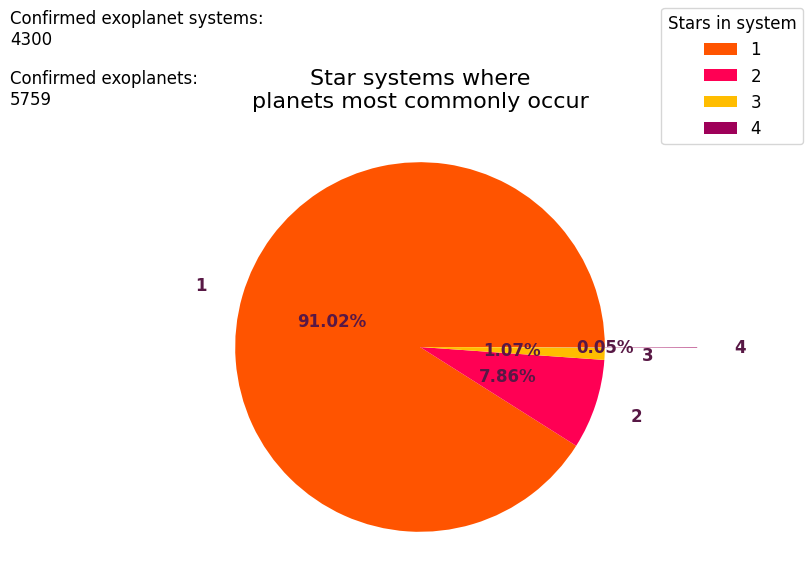

In [64]:
# create figure for chart and text to display on
fig, ax = plt.subplots(figsize=(8, 6))
# Array of the dataframe index == star count for the legend
labels = observation_by_stars.index.values
# explode hard to see data
explode = (0, 0, 0, 0.5)
colors = ['#ff5400', '#ff0054', '#ffbd00', '#9e0059']

# create pie chart
ax.pie(
    observation_by_stars, 
    colors=colors, 
    explode=explode, 
    labels=labels, 
    autopct='%1.2f%%', 
    pctdistance=0.5, 
    labeldistance=1.2, 
    textprops={'size' : 'large', 'color': '#581845', 'weight': 'bold'}
)

ax.set_title(
    "Star systems where\nplanets most commonly occur",
    fontsize=16
    )

# allow legend to be set to fig not ax
fig.legend(
    labels, 
    title="Stars in system", 
    title_fontsize=12, loc=1,
    fontsize=12
    )

# print count of rows from cleaned data as it will match systems with confirmed exoplanets
text1 = f"Confirmed exoplanet systems:\n{stellar_df['sy_pnum'].count()}"
# print sum of system planets column as all values will match the total amount of exoplanets 
text2 = f"Confirmed exoplanets:\n{stellar_df['sy_pnum'].sum()}"
fig.text(0, 1, text1, size=12)
fig.text(0, 0.9, text2, size=12)
plt.show()

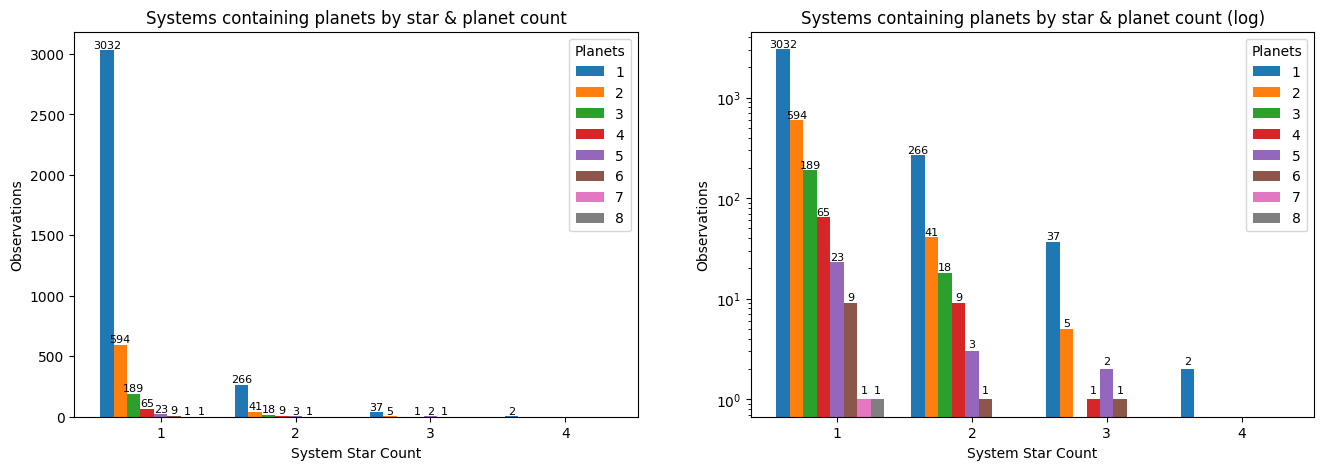

In [65]:
#df when grouping by sy_snum and sy_pnum by size() and unstacked(make missing data == 0 for table)
grouped = stellar_df.groupby(['sy_snum', 'sy_pnum']).size().unstack(fill_value=0)

# create a figure that contains 2 plots 
fig, ax = plt.subplots(1, 2, figsize=(16, 5))

bar_width = 0.1
# returns [0, 1, 2, 3]
indices = np.arange(len(grouped))

# for both plts (as they are the same in exception of 1 being log)
i = 0
while i < 2:
    # j = 0, sy_pnum_val = j+1
    for j, sy_pnum_val in enumerate(grouped.columns):
        # label = creates the planets 1-8 side labels legend
        bars = ax[i].bar(x=indices + j * bar_width, height=grouped[sy_pnum_val], width=bar_width, label=f'{sy_pnum_val}')

        # print observation values atop the bars
        for bar in bars:
            yval = bar.get_height()
            if yval > 0:
                ax[i].text(bar.get_x() + bar.get_width()/2, yval + 0.1, int(yval), ha='center', va='bottom', fontsize=8)
    i += 1

ax[0].set_xlabel('System Star Count')
ax[0].set_ylabel('Observations')
ax[0].set_title('Systems containing planets by star & planet count')
ax[0].set_xticks(indices + bar_width * 4)
ax[0].set_xticklabels(grouped.index)
ax[0].legend(title='Planets')


ax[1].set_yscale('log')
ax[1].set_xlabel('System Star Count')
ax[1].set_ylabel('Observations')
ax[1].set_title('Systems containing planets by star & planet count (log)')
ax[1].set_xticks(indices + bar_width * 4)
ax[1].set_xticklabels(grouped.index)
ax[1].legend(title='Planets')

plt.show()

> ^ Above: creates side by side representations of planet frequency to singluar star systems and binary star systems. One is an actual visual representation of the frequencies in relation to one another and the other is a log representaion to make the results more readable as there is great variance of the data 